# Naive Bayes Classifier From Scratch
In this experiment, the Naive Bayes method will be implemented from scratch using PyTorch.<br>
We will train our model on the [Student Alcohol Consumption](https://www.kaggle.com/uciml/student-alcohol-consumption) dataset to try to predict if a student frequently drink alcohol or not.

The data contains the following attributes:
- school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
- sex - student's sex (binary: 'F' - female or 'M' - male)
- age - student's age (numeric: from 15 to 22)
- address - student's home address type (binary: 'U' - urban or 'R' - rural)
- famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
- Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
- Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
- Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
- reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
- guardian - student's guardian (nominal: 'mother', 'father' or 'other')
- traveltime - home to school travel time (numeric: 1 - 1 hour)
- studytime - weekly study time (numeric: 1 - 10 hours)
- failures - number of past class failures (numeric: n if 1<=n<3, else 4)
- schoolsup - extra educational support (binary: yes or no)
- famsup - family educational support (binary: yes or no)
- paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
- activities - extra-curricular activities (binary: yes or no)
- nursery - attended nursery school (binary: yes or no)
- higher - wants to take higher education (binary: yes or no)
- internet - Internet access at home (binary: yes or no)
- romantic - with a romantic relationship (binary: yes or no)
- famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
- freetime - free time after school (numeric: from 1 - very low to 5 - very high)
- goout - going out with friends (numeric: from 1 - very low to 5 - very high)
- health - current health status (numeric: from 1 - very bad to 5 - very good)
- absences - number of school absences (numeric: from 0 to 93)
- G1 - first period grade (numeric: from 0 to 20)
- G2 - second period grade (numeric: from 0 to 20)
- G3 - final grade (numeric: from 0 to 20, output target)
- Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
- Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)

In [276]:
import os
import math
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

### Read csv with Pandas

In [277]:
students_mat = pd.read_csv(os.path.join('data', 'student-mat.csv'))
students_por = pd.read_csv(os.path.join('data', 'student-por.csv'))

In [278]:
# Concatenating students data from math and portuguese class
students = pd.concat([students_mat, students_por], axis=0)

In [279]:
# Averaging three grades into one single grade
students['grade'] = (students['G1'] + students['G1'] + students['G3']) / 3

# Combining weekly and weekend alcohol consumption into a single attribute
students['alc'] = students['Walc'] + students['Dalc']

# Drop the combined columns
students = students.drop(columns=['G1', 'G2', 'G3', 'school'])

In [280]:
students.head(3)

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,grade,alc
0,F,18,U,GT3,A,4,4,at_home,teacher,course,...,no,4,3,4,1,1,3,6,5.333333,2
1,F,17,U,GT3,T,1,1,at_home,other,course,...,no,5,3,3,1,1,3,4,5.333333,2
2,F,15,U,LE3,T,1,1,at_home,other,other,...,no,4,3,2,2,3,3,10,8.000000,5


### Transform string to categorical values

In [281]:
categorical_dict = {}
for col in students.columns:
    # For each column of type object, use sklearn label encoder and add the mapping to a dictionary
    if students[col].dtype == 'object':
        le = LabelEncoder() 
        students[col] = le.fit_transform(students[col])
        categorical_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [282]:
pprint(categorical_dict)

{'Fjob': {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4},
 'Mjob': {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4},
 'Pstatus': {'A': 0, 'T': 1},
 'activities': {'no': 0, 'yes': 1},
 'address': {'R': 0, 'U': 1},
 'famsize': {'GT3': 0, 'LE3': 1},
 'famsup': {'no': 0, 'yes': 1},
 'guardian': {'father': 0, 'mother': 1, 'other': 2},
 'higher': {'no': 0, 'yes': 1},
 'internet': {'no': 0, 'yes': 1},
 'nursery': {'no': 0, 'yes': 1},
 'paid': {'no': 0, 'yes': 1},
 'reason': {'course': 0, 'home': 1, 'other': 2, 'reputation': 3},
 'romantic': {'no': 0, 'yes': 1},
 'schoolsup': {'no': 0, 'yes': 1},
 'sex': {'F': 0, 'M': 1}}


Here is the dictonary of the categorical labels

### Correlation heatmap

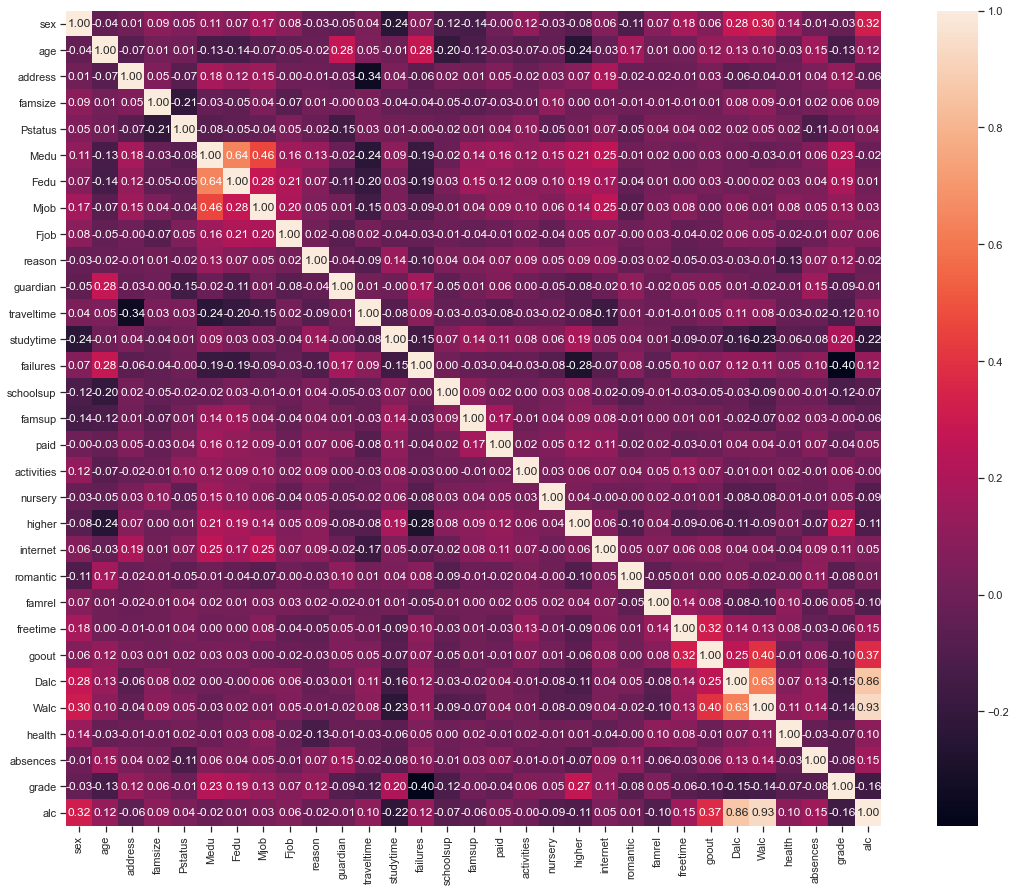

In [283]:
plt.figure(figsize=(20, 15))
sns.heatmap(students.corr(), annot=True, square=True, fmt='0.2f')

Just from the correlation heatmap, we can have an overview of the impact of alcohol consumption on students.
Based on the linear correlation between the target and the features, students consuming alcohol frequently have more chance to:
- have lower grades
- have more absences
- hang out more often
- does not aim to achieve higher education
- study less

Among all theses cases, the attributes that are the most correlated with the target are the grades, the study time and if the student is a men.

### Impact of alcohol consumption on students life

In [284]:
def plot_pie(data, column, ax):
    counts = data[column].value_counts()
    percent = counts / counts.sum() * 100
    labels = alc_workday.index
    ax.pie(x=percent, labels=labels, autopct='%1.0f%%')

Text(0.5, 1.0, 'Weekend Alcohol Consumption')

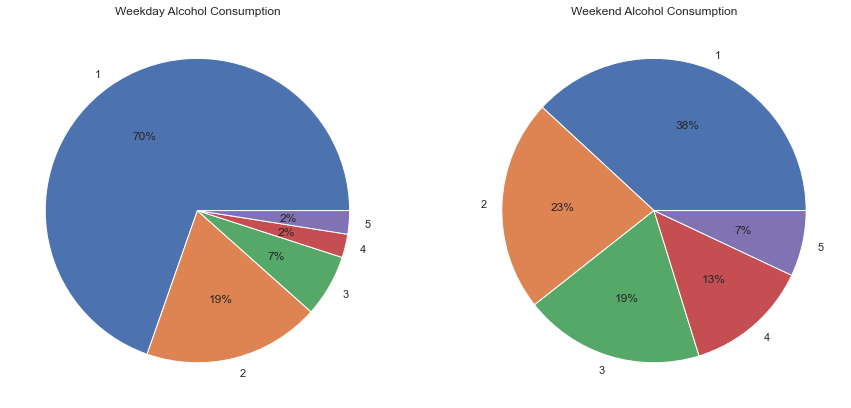

In [285]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
plot_pie(students, column='Dalc', ax=ax1)
plot_pie(students, column='Walc', ax=ax2)
ax1.set_title('Weekday Alcohol Consumption')
ax2.set_title('Weekend Alcohol Consumption')

The alcohol consumption during workdays is relatively low compared to the weekend consumption. Most students prefer to stay sober during workdays.<br>
Let's see how those behaviors have an impact on students success and life.

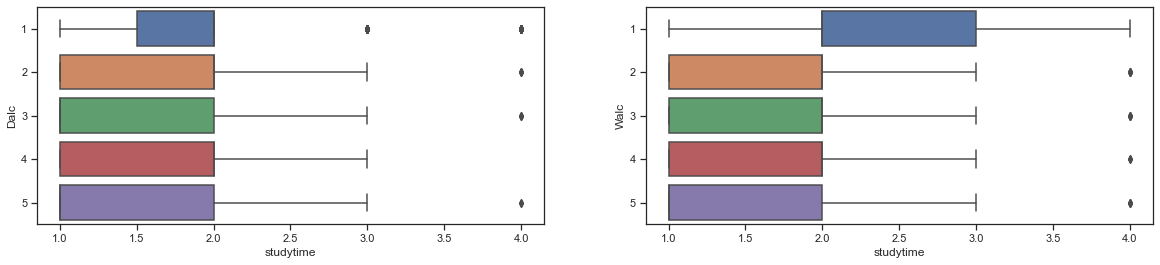

In [286]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
sns.boxplot(y='Dalc', x='studytime', orient='h', data=students, ax=ax1)
sns.boxplot(y='Walc', x='studytime', orient='h', data=students, ax=ax2)

Students who does not drink alcohol during weekdays usually study more than the ones who do.<br>
But the amount of study hours of students who does not drink the weekend is much more than the ones who do.

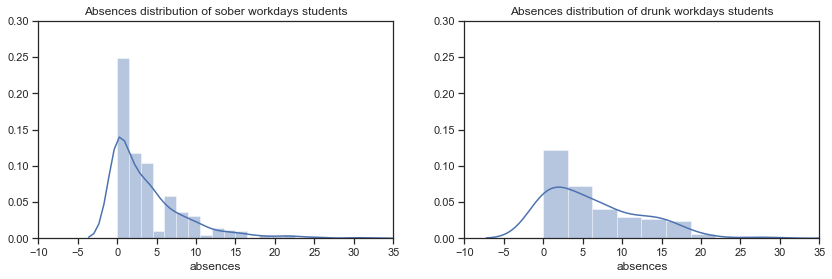

In [287]:
sober_absences = students.loc[students['Dalc'] <= 2, 'absences']
drunk_absences = students.loc[students['Dalc'] > 2, 'absences']
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.set_xlim(-10, 35)
ax2.set_xlim(-10, 35)
ax1.set_ylim(0, 0.30)
ax2.set_ylim(0, 0.30)
ax1.set_title('Absences distribution of sober workdays students')
ax2.set_title('Absences distribution of drunk workdays students')
sns.distplot(sober_absences, ax=ax1)
sns.distplot(drunk_absences, ax=ax2)

Students who drink two times or more a week have a lot more absences.<br>

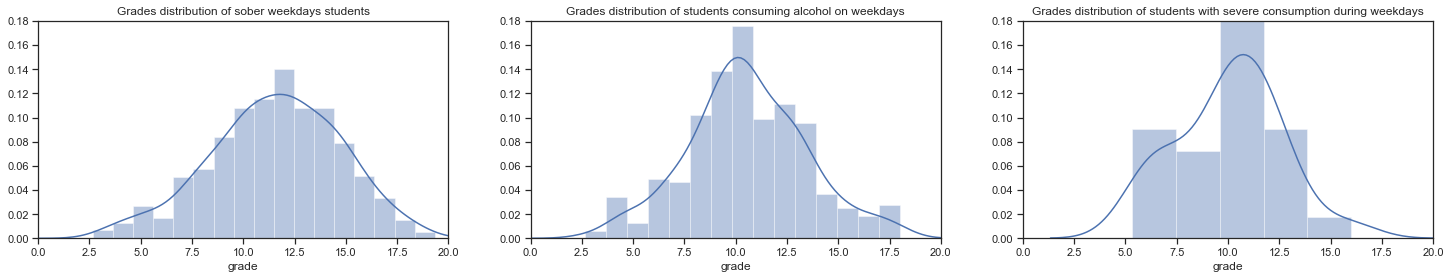

In [288]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 4))
sober_grades = students.loc[students['Dalc'] == 1, 'grade']
drunk_grades = students.loc[students['Dalc'] > 1, 'grade']
severe_drunk_grades = students.loc[students['Dalc'] == 5, 'grade']
ax1.set_ylim(0, 0.18)
ax2.set_ylim(0, 0.18)
ax3.set_ylim(0, 0.18)
ax1.set_xlim(0, 20)
ax2.set_xlim(0, 20)
ax3.set_xlim(0, 20)
ax1.set_title('Grades distribution of sober weekdays students')
ax2.set_title('Grades distribution of students consuming alcohol on weekdays')
ax3.set_title('Grades distribution of students with severe consumption during weekdays')
sns.distplot(sober_grades, ax=ax1)
sns.distplot(drunk_grades, ax=ax2)
sns.distplot(severe_drunk_grades, ax=ax3)

Students how drink even a little during workdays have lower grades than those who do not.<br>
The impact on grades is much more important for students with severe consumption.<br>

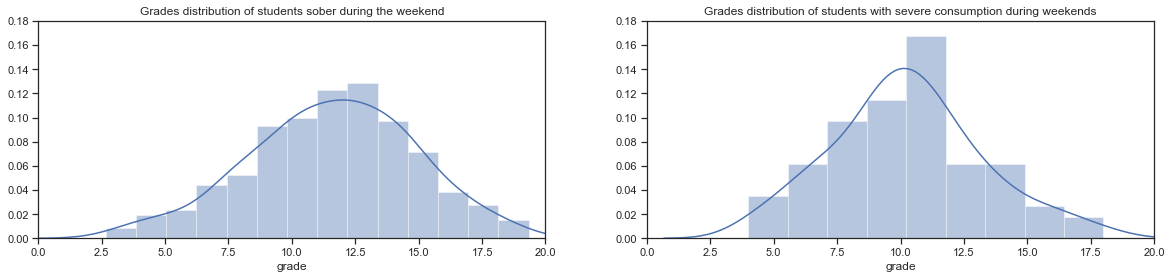

In [289]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
sober_grades = students.loc[students['Walc'] == 1, 'grade']
severe_drunk_grades = students.loc[students['Walc'] == 5, 'grade']
ax1.set_ylim(0, 0.18)
ax2.set_ylim(0, 0.18)
ax1.set_xlim(0, 20)
ax2.set_xlim(0, 20)
ax1.set_title('Grades distribution of students sober during the weekend')
ax2.set_title('Grades distribution of students with severe consumption during weekends')
sns.distplot(sober_grades, ax=ax1)
sns.distplot(severe_drunk_grades, ax=ax2)

However, alcohol consumption during the weekend has little impact on student grades.

### Converting alcohol consumption to a categorical label
The original label goes from 1 to 5 from no consumption to severe consumption.<br>
It makes more sense to try to predict the weekly consumption of students so we combined the two attributes by summing them.<br>

The fourth values seems like a good threshold to create two categorical classes:
- $[2, 3]$ little alcohol consumption 
- $[4, 5]$ moderate alcohol consumption
- $[6, 10]$ severe alcohol consumption

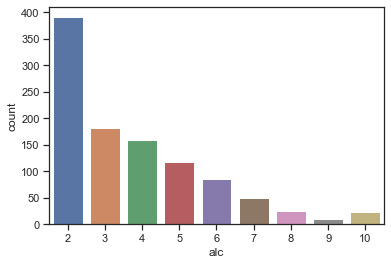

In [290]:
sns.countplot(students['alc'])

In [291]:
# Converting weekly consumption to classes
students.loc[students['alc'] <= 3, 'alc'] = 0                            # little 
students.loc[(students['alc'] > 3) & (students['alc'] <= 5), 'alc'] = 1  # moderate
students.loc[students['alc'] > 5, 'alc'] = 2                             # severe

In [292]:
# We need to distinguish categorical from numeric values to fit different distribution
# when we will fit the model
numeric_cols = ['age',
                'traveltime',
                'studytime',
                'failures',
                'famrel',
                'freetime',
                'goout',
                'health',
                'absences',
                'grade',
                'alc']

In [293]:
students = students.drop(columns=['Walc', 'Dalc'])

In [294]:
is_categorical = []
for col in students.columns:
    if col in numeric_cols:
        is_categorical.append(0)
    else:
        is_categorical.append(1)

In [295]:
X = torch.from_numpy(students.iloc[:, :-1].values).float()
y = torch.from_numpy(students.iloc[:, -1].values).float()

### Naive Bayes Classifier
Considering a vector of discrete values $\boldsymbol{x} \in \{1, \dots, K\}^D$, where $K$ is the number of samples and $D$ the number of features.
The naive bayes classifier assumes that the data is conditionally independant given the class label i.e $p(\boldsymbol{x}|y=c)$.
This assumption allows us to write the class conditional density as a product:

$$
    \large p(\boldsymbol{x} | y = c, \boldsymbol{\theta}) = \prod_{i=1}^{K}p(x_i | y_i = c, \boldsymbol{\theta}_{ic})
$$

The model is called “naive” since we do not expect the features to be independent, even conditional on the class label.

Assuming the bayes theorem:

$$
    \large P(A|B) = \frac{P(A)P(B|A)}{P(B)}
$$

It is easy to reformulate it to have a clearer understanding of how the classifier works:

$$
    \large P(\text{class}|\text{sample}) = \frac{P(\text{class})P(\text{sample}|\text{class})}{P(\text{sample})}
$$

Given a new sample, we want to predict its class. We will compute $P(\text{sample}|\text{class})P(\text{sample})$ according to the training data.<br>
When predicting, we compute:

$$
    \large P(c_j|x_i) \sim P(c_j)P(x_i|c_j)\dots P(x_D|c_j)
$$

In other words, for each potential class, we multiply the probability of the class (prior) with the probability of finding each features of $x_i$ in each class $c_j$ (posterior).

For categorical or binay features, we group the training samples according to each class
The form of the class-conditional density depends on the type of each feature. We give some possibilities below:

- For real values, we can use the Gaussian distribution:

$$
    \large p(\boldsymbol{x} | y = c, \boldsymbol{\theta}) = \prod_{i=1}^{D} \mathcal{N}(x_i| \mu_{ic}, \sigma_{ic}^2)
$$

- For binary values, we can use a Bernouilli distribution, where $\mu_{ic}$ is the probability that feature $i$ occurs in class $c$:

$$
    \large p(\boldsymbol{x} | y = c, \boldsymbol{\theta}) = \prod_{i=1}^{D} \text{Ber}(x_i | \mu_{ic}) 
$$

- For categorical features, we can use a Multinouilli distribution, where $\boldsymbol{\mu}_{ic}$ is an histogram over the possible values for $x_i$ in class $c$:

$$
    \large p(\boldsymbol{x} | y = c, \boldsymbol{\theta}) = \prod_{i=1}^{D}\text{Cat}(x_i | \boldsymbol{\mu}_{ic})
$$

These are the training steps:
- group data according to the class label $c_i$
- compute the prior probability i.e $p(c_i)$ the proportion of samples inside each class $c_i$
- for each feature:
    - if the feature is categorical, compute $p(\boldsymbol{x_j} | c_i)$ for $j = 1, \dots, D$ and $i = 1, \dots, C$:
        - for each possible values of this feature in the training samples of class $c_i$, compute the probability that this feature appears in class $c_i$
    - if the feature is continuous, compute $p(\boldsymbol{x_j} | c_i)$ for $j = 1, \dots, D$ and $i = 1, \dots, C$:
        - compute the mean $\mu$ and standard deviation $\sigma$ of the training samples of class $c_i$ and fit a normal distribution $\mathcal{N}(\mu, \sigma^2)$

To predict on a new samples:
- for each class $c_i$, compute $p(c_i | x)$ as:
    - multiply the prior of each class $p(c_i)$ by:
    - for each features $k$:
        - if categorical, multiply by the probabilities calculated earlier $p(\boldsymbol{x_k} | c_i)$ where $x_k$ is the value of the input on feature $k$.
        - if continuous, multiply by $\mathcal{N}(x_k | \mu, \sigma^2)$ the likelihood of the gaussian distribution given the input $x_k$
- return the highest probability $p(c_i | x)$ of all classes

In [296]:
class NaiveBayesClassifier(BaseEstimator):
    def __init__(self, offset=1):
        # Offset to smooth probability to avoid that a posterior probability be 0
        self.offset = offset
    
    def fit(self, X, y, **kwargs):
        # It is mandatory to pass a list describing if each feature is categorical or numerical
        if 'is_categorical' not in kwargs:
            raise ValueError('must pass \'is_categorical\' to fit through **kwargs')
        self.is_categorical = kwargs['is_categorical']
        size = X.shape[0]
        
        self.nb_features = X.shape[1]
        y_uvals = y.unique()
        self.nb_class = len(y_uvals)
        # Probability of each class in the training set
        self.class_probs = y.int().bincount().float() / size
        
        features_maxvals = torch.zeros((self.nb_features,), dtype=torch.int32)
        for j in range(self.nb_features):
            features_maxvals[j] = X[:, j].max()
        
        # All the posterior probabilites
        cond_probs = [] 
        for i in range(self.nb_class):
            cond_probs.append([])
            # Group samples by class
        
            idx = torch.where(y == y_uvals[i])[0]
            elts = X[idx]
            
            size_class = elts.shape[0]
            for j in range(self.nb_features):
                cond_probs[i].append([])
                if self.is_categorical[j]:
                    # If categorical
                    # For each features
                    for k in range(features_maxvals[j] + 1):
                        # Count the number of occurence of each value in this feature given the group class
                        # Divided by the number of samples in the class
                        p_x_k = (torch.where(elts[:, j] == k)[0].shape[0] + self.offset) / size_class
                        # Append to posteriors probabilities
                        cond_probs[i][j].append(p_x_k)
                else:
                    # If numerical
                    features_class = elts[:, j]
                    # Compute mean and std
                    mean = features_class.mean()
                    std = (features_class - mean).pow(2).mean().sqrt()
                    # Store these value to use them for the gaussian likelihood
                    cond_probs[i][j] = [mean, std]
        self.cond_probs = cond_probs
        return 0
    
    def gaussian_likelihood(self, X, mean, std):
        return (1 / (2 * math.pi * std.pow(2))) * torch.exp(-0.5 * ((X - mean) / std).pow(2))
    
    def predict(self, X):
        if len(X.shape) == 1:
            X = X.unsqueeze(0)
        
        nb_samples = X.shape[0]
        pred_probs = torch.zeros((nb_samples, self.nb_class), dtype=torch.float32)
        for k in range(nb_samples):
            elt = X[k]
            for i in range(self.nb_class):
                # Set probability by the prior (class probability)
                pred_probs[k][i] = self.class_probs[i]
                prob_feature_per_class = self.cond_probs[i]
                for j in range(self.nb_features):
                    if self.is_categorical[j]:
                        # If categorical get the probability of drawing the value of the input on feature j
                        # inside class i
                        pred_probs[k][i] *= prob_feature_per_class[j][elt[j].int()]
                    else:
                        # If numerical, multiply by the gaussian likelihood with parameters
                        # mean and std of the class i on feature j
                        mean, std = prob_feature_per_class[j]
                        pred_probs[k][i] *= self.gaussian_likelihood(elt[j], mean, std)
        # Get to highest probability among all classes
        return pred_probs.argmax(dim=1)

In [297]:
nbc = NaiveBayesClassifier()

fit_params = {'is_categorical' : is_categorical}
cross_val_score(nbc, X, y, cv=5, scoring='accuracy', fit_params=fit_params).mean()

0.5689409274935591

### Conclusion
Even if the naive bayes model makes a strong assumption that the features are conditionaly independant given the class label, it achieved almost 57% accuracy on three potential output classes.<br>
This model does not perform as well as the more sophisticated models but it is very fast and suited as a baseline model for most classification tasks.
On the other hand, naive bayes models can be descent predictors, they are considered as bad estimators i.e the output probability are not to be taken seriously.
The naive bayes technique is performing better than logistic regression on small datasets, whereas it is the opposite for large datasets.